In [1]:
#Metadados
__author__ = "Luidy"
__version__ = "1.0.0"
__status__ = "Implementando Dataset Synthea"

#Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ferramentas de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Configuração visual
sns.set(style="whitegrid")

In [2]:
#definindo função para fins melhor vizualização dos resultados
def linha():
    print('-'*60)
    print()

In [3]:
#carregando dataset
arquivo = 'synthea-pt150k-lc-data-sel-convert.csv'
print("carregando dataset...")
try:
    #df_sujo = dataframe sujo
    df_sujo = pd.read_csv(arquivo, low_memory=False)
    print("Dataset carregado com susseco!")
    linha()
except:
    print("Houve algum problema na importação do dataset")
    raise
print(f"Corpo original do dataframe:{df_sujo.shape}")
df_sujo.head()

carregando dataset...
Dataset carregado com susseco!
------------------------------------------------------------

Corpo original do dataframe:(22811, 788)


,ptnum,label,scc,C-103579009,C-125680007,C-186034007,C-263495000,C-398070004,C-424144002,C-72514-3,...,C-92139-5,C-92140-3,C-92141-1,C-92142-9,C-94040-3,C-979092,C-993452,C-997501,C-999998,C-999999
0,p3818.4,1,165,white,m,nonhispanic,m,massachusetts,50t70,abnormal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p15865,1,150,white,m,nonhispanic,m,massachusetts,gt70,abnormal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,p23282.4,1,146,white,m,nonhispanic,m,massachusetts,50t70,normal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p5834.2,1,146,asian,m,hispanic,m,massachusetts,gt70,normal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p27452,1,145,white,m,nonhispanic,m,massachusetts,gt70,normal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Criando um dicionario para a tradução posteriormente

print("Selecionando quais melhores atributos para treinamento..")
linha()

mapa_colunas = {
    'label':       'Target',           # 0=Saudável, 1=Câncer
    'C-424144002': 'Idade',            # Faixa Etária
    'C-263495000': 'Genero',           # M/F
    'C-72166-2':   'Fumo',             # Histórico de Fumo
    'C-267036007': 'Falta_de_Ar',
    'C-66857006':  'Tosse_com_Sangue',
    'C-39156-5':   'IMC',              # Índice de Massa Corporal
    'C-2708-6':    'Saturacao_Oxigenio',
    'C-49727002':  'Tosse',
    'C-84229001':  'Fadiga',
    'C-7200002':   'Alcoolismo',
    'C-56018004':  'Chiado_no_Peito'
}

#filtrando o dataframe apenas para as colunas que serão utilizadas para o treinamento do modelo
print("Filtrando atributos do dataframe... ")
linha()

colunas_existentes = []
for c in mapa_colunas.keys():
    if c in df_sujo.columns:
        colunas_existentes.append(c)
#df = Dataframe
df = df_sujo[colunas_existentes].rename(columns=mapa_colunas).copy()

print(f"Dimensões atuais do dataframe:{df.shape}")
linha()

for i in df.columns:
    print(f"🔸 {i}: {df[i].unique()}")

print("-" * 40)

Selecionando quais melhores atributos para treinamento..
------------------------------------------------------------

Filtrando atributos do dataframe... 
------------------------------------------------------------

Dimensões atuais do dataframe:(22811, 12)
------------------------------------------------------------

🔸 Target: [1 0]
🔸 Idade: ['50t70' 'gt70' '30t50']
🔸 Genero: ['m' 'f']
🔸 Fumo: ['former' 'never' nan]
🔸 Falta_de_Ar: [nan True]
🔸 Tosse_com_Sangue: [nan True]
🔸 IMC: ['abnormal' 'normal' nan]
🔸 Saturacao_Oxigenio: [nan 'abnormal']
🔸 Tosse: [nan True]
🔸 Fadiga: [nan True]
🔸 Alcoolismo: [nan True]
🔸 Chiado_no_Peito: [nan True]
----------------------------------------


In [7]:
#traduzindo valores categoricos do dataframe para portugues

if "Fumo" in df.columns:
    df['Fumo'] = df['Fumo'].fillna('Fumante_atual')
    df["Fumo"] = df["Fumo"].replace({'never':'Nunca_fumou','former':'Ex_fumante'})

if "Idade" in df.columns:
    df["Idade"] = df["Idade"].replace({
        "50t70":"50_a_70_anos",
        "gt70":"Mais_de_70",
        "30t50":"Menos_de_50"
    })

if "Genero" in df.columns:
    df["Genero"] = df["Genero"].replace({'m':'M',"f":"F"})


for i in df.columns:
    print(f"🔸 {i}: {df[i].unique()}")

print("-" * 40)

print(f"Dimensões atuais do dataframe: {df.shape}")
df.head()

🔸 Target: [1 0]
🔸 Idade: ['50_a_70_anos' 'Mais_de_70' 'Menos_de_50']
🔸 Genero: ['M' 'F']
🔸 Fumo: ['Ex_fumante' 'Nunca_fumou' 'Fumante_atual']
🔸 Falta_de_Ar: [nan True]
🔸 Tosse_com_Sangue: [nan True]
🔸 IMC: ['abnormal' 'normal' nan]
🔸 Saturacao_Oxigenio: [nan 'abnormal']
🔸 Tosse: [nan True]
🔸 Fadiga: [nan True]
🔸 Alcoolismo: [nan True]
🔸 Chiado_no_Peito: [nan True]
----------------------------------------
Dimensões atuais do dataframe: (22811, 12)


,Target,Idade,Genero,Fumo,Falta_de_Ar,Tosse_com_Sangue,IMC,Saturacao_Oxigenio,Tosse,Fadiga,Alcoolismo,Chiado_no_Peito
0,1,50_a_70_anos,M,Ex_fumante,NaN,NaN,abnormal,NaN,NaN,NaN,NaN,NaN
1,1,Mais_de_70,M,Ex_fumante,NaN,NaN,abnormal,NaN,NaN,NaN,NaN,NaN
2,1,50_a_70_anos,M,Ex_fumante,NaN,NaN,abnormal,abnormal,NaN,NaN,NaN,NaN
3,1,Mais_de_70,M,Nunca_fumou,NaN,NaN,abnormal,NaN,NaN,NaN,NaN,NaN
4,1,Mais_de_70,M,Nunca_fumou,NaN,NaN,abnormal,NaN,NaN,NaN,NaN,NaN


In [8]:
sintomas = [
    'Tosse', 
    'Fadiga', 
    'Falta_de_Ar', 
    'Chiado_no_Peito', 
    'Tosse_com_Sangue',
    'Alcoolismo'
]

# 2. O Loop Mágico
print("Preenchendo vazios com False nos sintomas...")

for col in sintomas:
    # Verifica se a coluna existe para não dar erro
    if col in df.columns:
        df[col] = df[col].fillna(False)

for i in df.columns:
    print(f"🔸 {i}: {df[i].unique()}")

print("-" * 40)

Preenchendo vazios com False nos sintomas...
🔸 Target: [1 0]
🔸 Idade: ['50_a_70_anos' 'Mais_de_70' 'Menos_de_50']
🔸 Genero: ['M' 'F']
🔸 Fumo: ['Ex_fumante' 'Nunca_fumou' 'Fumante_atual']
🔸 Falta_de_Ar: [False  True]
🔸 Tosse_com_Sangue: [False  True]
🔸 IMC: ['abnormal' 'normal' nan]
🔸 Saturacao_Oxigenio: [nan 'abnormal']
🔸 Tosse: [False  True]
🔸 Fadiga: [False  True]
🔸 Alcoolismo: [False  True]
🔸 Chiado_no_Peito: [False  True]
----------------------------------------


C:\Users\Luidy\AppData\Local\Temp\ipykernel_300\2403216472.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False)


In [9]:
sintomas = [
    'Saturacao_Oxigenio',
    'IMC'
]

# 2. O Loop Mágico
print("Preenchendo vazios com False nos sintomas...")

for col in sintomas:
    # Verifica se a coluna existe para não dar erro
    if col in df.columns:
        df[col] = df[col].fillna("Normal")

if 'Saturacao_Oxigenio' in df.columns:
    df['Saturacao_Oxigenio'] = df['Saturacao_Oxigenio'].replace({"normal":"Normal","abnormal":"Anormal"})
if 'IMC' in df.columns:
    df['IMC'] = df['IMC'].replace({"normal":"Normal","abnormal":"Anormal"})

for i in df.columns:
    print(f"🔸 {i}: {df[i].unique()}")

print("-" * 40)

Preenchendo vazios com False nos sintomas...
🔸 Target: [1 0]
🔸 Idade: ['50_a_70_anos' 'Mais_de_70' 'Menos_de_50']
🔸 Genero: ['M' 'F']
🔸 Fumo: ['Ex_fumante' 'Nunca_fumou' 'Fumante_atual']
🔸 Falta_de_Ar: [False  True]
🔸 Tosse_com_Sangue: [False  True]
🔸 IMC: ['Anormal' 'Normal']
🔸 Saturacao_Oxigenio: ['Normal' 'Anormal']
🔸 Tosse: [False  True]
🔸 Fadiga: [False  True]
🔸 Alcoolismo: [False  True]
🔸 Chiado_no_Peito: [False  True]
----------------------------------------


In [10]:
sintomas = [
    'Tosse', 
    'Fadiga', 
    'Falta_de_Ar', 
    'Chiado_no_Peito', 
    'Tosse_com_Sangue',
    'Alcoolismo'
]

for col in sintomas:
    if col in df.columns:
        df[col] = df[col].astype(int)

for i in df.columns:
    print(f"🔸 {i}: {df[i].unique()}")

print("-" * 40)

print(f"Dimensões atuais do dataframe: {df.shape}")
df.head(100)

🔸 Target: [1 0]
🔸 Idade: ['50_a_70_anos' 'Mais_de_70' 'Menos_de_50']
🔸 Genero: ['M' 'F']
🔸 Fumo: ['Ex_fumante' 'Nunca_fumou' 'Fumante_atual']
🔸 Falta_de_Ar: [0 1]
🔸 Tosse_com_Sangue: [0 1]
🔸 IMC: ['Anormal' 'Normal']
🔸 Saturacao_Oxigenio: ['Normal' 'Anormal']
🔸 Tosse: [0 1]
🔸 Fadiga: [0 1]
🔸 Alcoolismo: [0 1]
🔸 Chiado_no_Peito: [0 1]
----------------------------------------
Dimensões atuais do dataframe: (22811, 12)


,Target,Idade,Genero,Fumo,Falta_de_Ar,Tosse_com_Sangue,IMC,Saturacao_Oxigenio,Tosse,Fadiga,Alcoolismo,Chiado_no_Peito
0,1,50_a_70_anos,M,Ex_fumante,0,0,Anormal,Normal,0,0,0,0
1,1,Mais_de_70,M,Ex_fumante,0,0,Anormal,Normal,0,0,0,0
2,1,50_a_70_anos,M,Ex_fumante,0,0,Anormal,Anormal,0,0,0,0
3,1,Mais_de_70,M,Nunca_fumou,0,0,Anormal,Normal,0,0,0,0
4,1,Mais_de_70,M,Nunca_fumou,0,0,Anormal,Normal,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,Menos_de_50,F,Ex_fumante,0,0,Anormal,Normal,0,0,0,0
96,1,Mais_de_70,M,Ex_fumante,0,0,Anormal,Normal,0,0,0,0
97,1,Mais_de_70,M,Nunca_fumou,0,0,Anormal,Normal,0,0,0,0
98,1,Mais_de_70,M,Nunca_fumou,0,0,Anormal,Normal,0,0,0,0


In [11]:
#traduzindo as strings para boleano
df = pd.get_dummies(df,drop_first=True)
print("Dummies criados")
print("-"*40)

#definindo dependencias e independencias 
x = df.drop("Target", axis=1)
y = df["Target"]

#definindo variaveis para treinamento e teste
x_treino,x_teste,y_treino,y_teste = train_test_split(x,y,test_size=0.3,random_state=42)
print("Variaveis de treinamento Definidas")
print("-"*40)

#configurando validação cruzada
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("Validação cruzada Configurada")
print("-"*40)

#definindo algoritimos para a comparação de desempenho
algoritimos = {
    "Regressão Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Árvore de Decisão":   DecisionTreeClassifier(random_state=42),
    "Random Forest":       RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (Support Vector)": SVC(probability=True, random_state=42),
    "Gradient Boosting":   GradientBoostingClassifier(random_state=42)
}
print("Algoritimos para avaliação definidos")
print("-"*40)

print(f"Dimensões atuais do dataframe: {df.shape}")
df.head()

Dummies criados
----------------------------------------
Variaveis de treinamento Definidas
----------------------------------------
Validação cruzada Configurada
----------------------------------------
Algoritimos para avaliação definidos
----------------------------------------
Dimensões atuais do dataframe: (22811, 14)


,Target,Falta_de_Ar,Tosse_com_Sangue,Tosse,Fadiga,Alcoolismo,Chiado_no_Peito,Idade_Mais_de_70,Idade_Menos_de_50,Genero_M,Fumo_Fumante_atual,Fumo_Nunca_fumou,IMC_Normal,Saturacao_Oxigenio_Normal
0,1,0,0,0,0,0,0,False,False,True,False,False,False,True
1,1,0,0,0,0,0,0,True,False,True,False,False,False,True
2,1,0,0,0,0,0,0,False,False,True,False,False,False,False
3,1,0,0,0,0,0,0,True,False,True,False,True,False,True
4,1,0,0,0,0,0,0,True,False,True,False,True,False,True


In [12]:
melhor_algoritimo_nome = ""
melhor_algoritimo_objeto = None
melhor_acuracia = 0
media_comparativa = 0

print(f"{'ALGORITMO':<25} | {'MÉDIA (CV)':<12} | {'ESTABILIDADE (Desvio)'}")
print("_"*65)
#cada agoritimo sera treinado e testado 10 vezes com
for nome, algoritimo in algoritimos.items():
    scores = cross_val_score(algoritimo,x_treino,y_treino,cv=kfold,scoring='accuracy')

    media = scores.mean()
    desvio = scores.std()

    print(f"{nome:<25} | {media*100:.2f}% | [+/-]{desvio*100:.2f}%")

    if media-desvio > media_comparativa:
        melhor_algoritimo_75_nome = nome
        melhor_algoritimo_75_objeto = algoritimo
        melhor_acuracia_75 = media
        media_comparativa_75 = media - desvio

print("-"*65)
print(f"Melhor algoritimo: {melhor_algoritimo_75_nome}")
print(f"com acuracia media de {melhor_acuracia_75*100:.2f}%")
    

ALGORITMO                 | MÉDIA (CV)   | ESTABILIDADE (Desvio)
_________________________________________________________________
Regressão Logística       | 85.43% | [+/-]0.88%
Árvore de Decisão         | 85.73% | [+/-]0.56%
Random Forest             | 85.73% | [+/-]0.56%
SVM (Support Vector)      | 85.75% | [+/-]0.57%
Gradient Boosting         | 85.38% | [+/-]0.72%
-----------------------------------------------------------------
Melhor algoritimo: Gradient Boosting
com acuracia media de 85.38%


In [13]:
melhor_algoritimo_nome = ""
melhor_algoritimo_objeto = None
melhor_acuracia = 0
media_comparativa = 0

print(f"{'ALGORITMO':<25} | {'MÉDIA (CV)':<12} | {'ESTABILIDADE (Desvio)'}")
print("_"*65)
#cada agoritimo sera treinado e testado 10 vezes com
for nome, algoritimo in algoritimos.items():
    scores = cross_val_score(algoritimo,x,y,cv=kfold,scoring='accuracy')

    media = scores.mean()
    desvio = scores.std()

    print(f"{nome:<25} | {media*100:.2f}% | [+/-]{desvio*100:.2f}%")

    if media-desvio > media_comparativa:
        melhor_algoritimo_nome = nome
        melhor_algoritimo_objeto = algoritimo
        melhor_acuracia = media
        media_comparativa = media - desvio
        
print("-"*65)
print(f"Melhor algoritimo: {melhor_algoritimo_nome}")
print(f"com acuracia media de {melhor_acuracia*100:.2f}%")
    

ALGORITMO                 | MÉDIA (CV)   | ESTABILIDADE (Desvio)
_________________________________________________________________
Regressão Logística       | 85.47% | [+/-]0.67%
Árvore de Decisão         | 85.76% | [+/-]0.36%
Random Forest             | 85.75% | [+/-]0.37%
SVM (Support Vector)      | 85.75% | [+/-]0.37%
Gradient Boosting         | 85.55% | [+/-]0.72%
-----------------------------------------------------------------
Melhor algoritimo: Árvore de Decisão
com acuracia media de 85.76%


In [14]:
print(f"Treinando o modelo com {melhor_algoritimo_75_nome}...")
linha()
modelo = melhor_algoritimo_75_objeto.fit(x_treino,y_treino)

previsoes = modelo.predict(x_teste)
acuracia = accuracy_score(y_teste,previsoes)

print(f"Modelo hold out com algoritimo {melhor_algoritimo_75_nome} apresenta precisão de {acuracia*100:.2f}%")
linha()

Treinando o modelo com Gradient Boosting...
------------------------------------------------------------

Modelo hold out com algoritimo Gradient Boosting apresenta precisão de 85.77%
------------------------------------------------------------



Text(42.25, 0.5, 'Realidade')

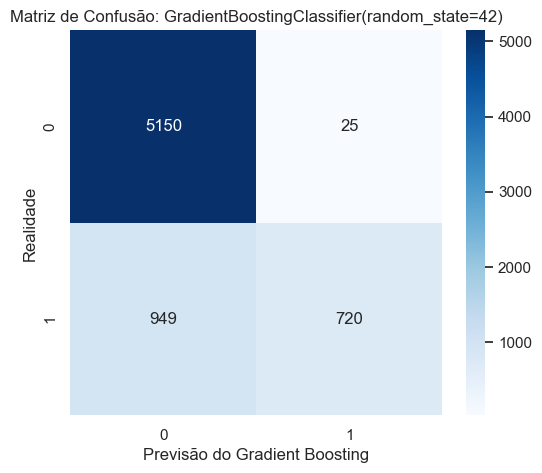

In [15]:
#criando matriz de erro
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_teste, previsoes), annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de Confusão: {modelo}")
plt.xlabel(f"Previsão do {melhor_algoritimo_75_nome}")
plt.ylabel("Realidade")

Text(0.5, 1.0, 'Os 10 Maiores Fatores de Risco - GradientBoostingClassifier(random_state=42)')

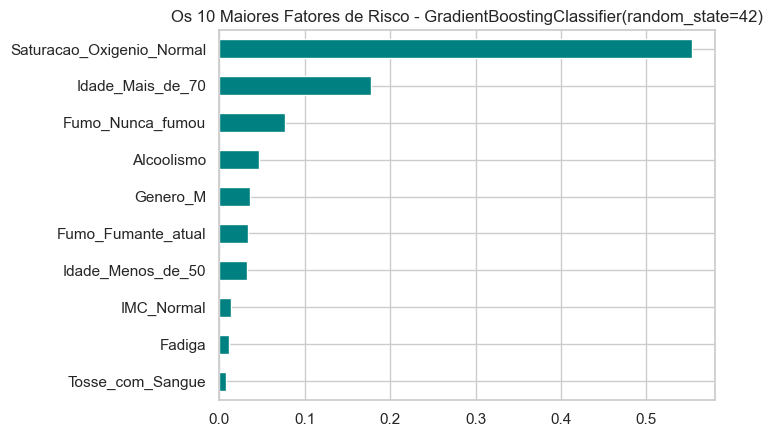

In [37]:
pureza = pd.Series(modelo.feature_importances_, index=x.columns)
pureza.nlargest(10).sort_values().plot(kind="barh", color="teal")
plt.title(f"Os 10 Maiores Fatores de Risco - {modelo}")